In [1]:
from google.colab import drive
drive.mount('/content/drive')
from torch import __version__
print(__version__)
from pickle import format_version
print(format_version)

Mounted at /content/drive
1.7.0+cu101
4.0


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from fastai import *
from fastai.text import *
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pickle

In [ ]:
bs=12
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# data_path='/home/taindp/Jupyter/ulmfit_intent/data/'
# data_path=os.path.dirname(data_path)
# models_path='/home/taindp/Jupyter/ulmfit_intent/models/'
# models_path=os.path.dirname(models_path)
data_path='/content/drive/MyDrive/Colab Notebooks/thesis/hcmut_sent_norm.csv'
# data_path=os.path.dirname(data_path)
models_path='/content/drive/My Drive/Colab Notebooks/data/models/'
# models_path=os.path.dirname(models_path)

## Create Dictionary Colab 

In [ ]:
# data_reload=pd.read_csv(os.path.join(data_path,'preTrain.csv'),encoding='utf-8')
# data_reload.columns=['id','content']
# print(data_reload['content'].head())
# data = (TextList.from_df(data_reload,cols='content')
#             .split_by_rand_pct(0.1, seed=42)
#             .label_for_lm()           
#             .databunch(bs=bs, num_workers=0))
# data.save(os.path.join(data_path,'vi_databunch'))
# len(data.vocab.itos),len(data.train_ds)
# data = load_data(data_path,'vi_databunch.pkl',bs=bs)
# data.train_ds
# learn = language_model_learner(data, AWD_LSTM, drop_mult=0.9, pretrained=False)
# lr = 1e-2
# lr *= bs/24
# learn.unfreeze()
# learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
# learn.save(os.path.join(data_path,'vi_wt'),with_opt=False)
# learn.data.vocab.save(os.path.join(data_path,'vi_wt_vocab.pkl'))

## Pretrain

In [ ]:
df = pd.read_csv(data_path)
df.loc[pd.isna(df.content),'content']='NA'
df.head()

,label,content
0,0,anh chị cho em hỏi với ạ 3 tháng nữa là em thi...
1,0,anh chị ơi cho em hỏi giữa ngành du lịch với n...
2,0,anh chị ơi cho em xin hỏi ngành quản trị kinh ...
3,0,cho em xin ít thông tin về ngành công tác xã h...
4,0,cho em xin ý kiến về ngành marketing đi ạ


In [ ]:
df_train,df_valid = train_test_split(df,stratify=df['label'],test_size=0.3,random_state=42)

In [ ]:
df_train.shape,df_valid.shape

((159, 2), (69, 2))

In [ ]:
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_valid, path = "")
# data_clas = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_valid, vocab=data_lm.train_ds.vocab, bs=bs)

In [ ]:
print(data_lm)

TextLMDataBunch;

Train: LabelList (159 items)
x: LMTextList
xxbos em chào mọi người ạ hiện em đã chọn được mình học kinh tế và phân vân 3 ngành tài chính ngân hàng kế toán quản trị kinh doanh,xxbos 1 số ngành em quan tâm là kinh doanh quốc tế kinh tế đối ngoại quản trị khách sạn quản trị lữ hành xxunk có anh chị nào đã tốt nghiệp các ngành xxunk tư vấn cho em với ạ,xxbos mọi người tư vấn cho em ngành tự động hoá cơ điện tử của đại học bách khoa hà nội với ạ,xxbos em muốn làm việc ở các xxunk xxunk công nghệ xxunk như xxunk xxunk thì nên chọn học ngành nào ở bách khoa ạ,xxbos em có đam mê với môn tin và công nghệ thông tin anh chị nào học công nghệ thông tin có thể tư vấn giúp em không
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (69 items)
x: LMTextList
xxbos em sinh năm xxunk có ý định học marketing hoặc quản trị kinh doanh,xxbos hiện em đã chọn được mình học kinh tế và phân vân 3 ngành tài chính ngân hàng kế toán quản trị kinh doanh,xxbos em sinh năm xxunk học khối c00 có đam mê m

In [ ]:
# df_learn=pd.concat([df_train,df_test],sort=False)

In [ ]:
# data_lm = (TextList.from_df(df_learn, cols='content')
#     .split_by_rand_pct(0.1, seed=42)
#     .label_for_lm()           
#     .databunch(bs=bs, num_workers=0))

In [ ]:
url_pth=os.path.join(models_path,'vi_wt')
url_pkl=os.path.join(models_path,'vi_wt_vocab')
lm_fns=[url_pth,url_pkl]

In [ ]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=0.5)

In [ ]:
lr = 1e-1
# lr *= bs/24

In [ ]:
learn_lm.fit_one_cycle(10,lr, moms=(0.85, 0.65))

epoch,train_loss,valid_loss,accuracy,time
0,6.120687,5.861932,0.133259,00:00
1,6.101028,5.560520,0.158036,00:00
2,6.021531,5.023423,0.189732,00:00
3,5.798100,4.451108,0.215848,00:00
4,5.527970,4.019951,0.252902,00:00
5,5.253072,3.737499,0.284821,00:00
6,5.004360,3.582537,0.306027,00:00
7,4.785074,3.488139,0.315402,00:00
8,4.600095,3.436481,0.321205,00:00
9,4.448460,3.424078,0.324107,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


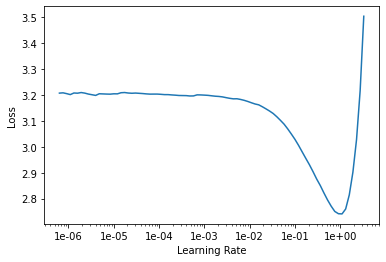

In [ ]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [ ]:
lr = 1e-1
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,3.230850,3.342225,0.331473,00:00
1,3.149469,3.316805,0.365848,00:00
2,2.984881,3.599825,0.335045,00:00
3,2.949221,3.150628,0.414955,00:00
4,2.807756,3.031205,0.433929,00:00
5,2.634061,2.916857,0.452902,00:00
6,2.465336,2.896836,0.460491,00:00
7,2.314932,2.894493,0.468527,00:00


In [ ]:
learn_lm.save(os.path.join(models_path,'vifine_tuned'))
learn_lm.save_encoder(os.path.join(models_path,'vifine_tuned_enc'))

In [ ]:
# bs=21
data_classify = (TextList.from_df(df, vocab=data_lm.vocab, cols='content')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=0))

In [ ]:
data_classify.save(os.path.join(models_path,'data_classify'))

In [ ]:
data_classify=load_data(models_path,'data_classify',bs=bs)

In [ ]:
# from fastai import F1ScoreMulti

In [ ]:
# acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(fbeta, thresh=0.5, beta = 1)
learn_c = text_classifier_learner(data_classify, AWD_LSTM, drop_mult=0.65, metrics=[accuracy])
learn_c.load_encoder(os.path.join(models_path,'vifine_tuned_enc'))
learn_c.freeze()

In [ ]:
lr=1e-1
lr *= bs/24

In [ ]:
learn_c.fit_one_cycle(8, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.613031,0.546099,0.772727,00:00
1,0.468828,0.457790,0.772727,00:00
2,0.533384,0.348295,0.818182,00:00
3,0.467842,0.371349,0.909091,00:00
4,0.451766,0.214632,0.909091,00:00
5,0.398659,0.189054,0.954545,00:00
6,0.355404,0.164804,0.954545,00:00
7,0.318458,0.170434,0.954545,00:00


In [ ]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.276923,0.389563,0.772727,00:01
1,0.507381,0.319093,0.909091,00:00


In [ ]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.547341,0.198934,0.954545,00:00
1,0.569434,0.380486,0.818182,00:00


In [ ]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(8, slice(lr/2/(2.6**4),lr/2), moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.588945,0.386859,0.863636,00:00
1,0.589031,0.341795,0.863636,00:00
2,0.568020,0.258745,1.000000,00:00
3,0.582576,0.404800,0.772727,00:00
4,0.575530,0.435753,0.863636,00:00
5,0.560710,0.290127,1.000000,00:00
6,0.539751,0.302924,0.954545,00:00
7,0.532574,0.301422,0.863636,00:00


In [ ]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.542649,0.341231,0.909091,00:01


In [ ]:
learn_c.save(os.path.join(models_path,'vi_classify'))